This code includes probabilty matching. Thus we can then work with  posterior instead of behaviour when doing parameter fitting.

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pdb
from scipy.optimize import minimize
from scipy.stats import multivariate_normal
from tqdm.notebook import tqdm
import random

In [13]:
def gaussian(x, mean, sigma):
    return np.exp(-(x-mean)**2/(2*sigma**2))

def posterior_array(log_freq_percept, n_tones, p_back, p_low, 
                    log_prior_low, log_prior_high):
    """
    Arguments: 
    log_freq_percept - range of all possible frequencies (percepts?)
    p_back - prob of background, p_low - prob of low condition
    log_prior_low - gaussian of low condition
    log_prior_high - gaussian of high condition
    """
    
    log_prior_low_mean = log_prior_low[0]; log_prior_low_sigma = log_prior_low[1];
    log_prior_high_mean = log_prior_high[0]; log_prior_high_sigma = log_prior_high[1];
    prior_low = gaussian(x=log_freq_percept, mean=log_prior_low_mean, sigma=log_prior_low_sigma)
    prior_high = gaussian(x=log_freq_percept, mean=log_prior_high_mean, sigma=log_prior_high_sigma)
    prior_dist_mixed_high = p_back*(1/len(log_freq_percept)) + (1-p_back)*prior_high \
    #mixture model with p(T|B) = 1/no. of possible freqs
    prior_dist_mixed_high /= prior_dist_mixed_high.sum() #normalizing
    prior_dist_mixed_high = np.expand_dims(prior_dist_mixed_high, axis = 1)
    prior_dist_mixed_low = p_back*(1/len(log_freq_percept)) + (1-p_back)*prior_low \
    #mixture model with p(T|B) = 1/no. of possible freqs
    prior_dist_mixed_low /= prior_dist_mixed_low.sum() #normalizing
    prior_dist_mixed_low = np.expand_dims(prior_dist_mixed_low, axis = 1)
    
    if n_tones == 3:
        prior_tones_low = np.expand_dims(prior_dist_mixed_low@np.transpose\
                                         (prior_dist_mixed_low),axis=2)@np.transpose(prior_dist_mixed_low) \
        #p(T1,T2..|L) 
        prior_tones_high = np.expand_dims(prior_dist_mixed_high@np.transpose\
                                          (prior_dist_mixed_high),axis=2)@np.transpose(prior_dist_mixed_high) \
        #p(T1,T2..|H) 
    elif n_tones == 2:
        prior_tones_low = prior_dist_mixed_low@np.transpose(prior_dist_mixed_low)
        prior_tones_high = prior_dist_mixed_high@np.transpose(prior_dist_mixed_high)
        
    elif n_tones == 1:
        prior_tones_low = prior_dist_mixed_low
        prior_tones_high = prior_dist_mixed_high
        
    normalizer = (1-p_low)*prior_tones_high + p_low*prior_tones_low #p(H)*p(T1,T2..|H) + p(L)*p(T1,T2..|L)
    posterior = prior_tones_high*(1-p_low)/normalizer
    # posterior /= np.sum(posterior)
    
    return prior_dist_mixed_high, prior_dist_mixed_low, posterior

In [20]:
# experimental task
def task(freq_seq, n_trials = 10, n_tones = 3, p_low = 0.5, p_back = 0.3):
    log_freq_seq_array = np.arange(np.log10(freq_seq[0]), np.log10(freq_seq[-1]), np.log10(1003/1000)*30)
    log_freq_seq_mid = np.median(log_freq_seq_array)
    log_freq_low = [log_freq_seq_mid - 0.2,0.1]  #low freq condition is gaussian 
    log_freq_high = [log_freq_seq_mid + 0.2,0.1] #high freq condition is gaussian
    trial_tones = []
    dist_chosen = []
    kind_of_tones = []

    for trial in range(n_trials):
        signal_rand = np.random.random()
        low_dist = signal_rand < p_low #choosing true tone from either low or high condition
        tones = []
        tone_kind = []
        for n_tone in range(n_tones):
            signal_back = np.random.random()
            background = signal_back < p_back #choosing background or true tone
            if background:
                nearest_log_tone = np.random.choice(log_freq_seq_array)
                #background freq is chosen from a uniform distribution
                tone_kind.append(0)
            else: 
                if low_dist:
                    tone = min(max(np.random.randn()*log_freq_low[1] + log_freq_low[0],\
                                   log_freq_seq_array[0]),log_freq_seq_array[-1])                    
                    tone_kind.append(1)
                else:
                    tone = min(max(np.random.randn()*log_freq_high[1] + log_freq_high[0],\
                                   log_freq_seq_array[0]),log_freq_seq_array[-1])
                    tone_kind.append(2)
                nearest_log_tone = log_freq_seq_array[np.argmin(np.abs(log_freq_seq_array - tone))]
            nearest_tone = freq_seq[np.argmin(np.abs(freq_seq - 10**nearest_log_tone))]        
            tones.append(nearest_tone)
        trial_tones.append(tones)
        dist_chosen.append(low_dist)
        kind_of_tones.append(tone_kind)
    return trial_tones, dist_chosen, kind_of_tones, log_freq_low, log_freq_high

In [21]:
"""
Throwing away repetitions in training and testing trials
"""

def unique(trial_list, dist_list, tone_kind_list): 
  
    # intilize a null list 
    unique_trial_list = [] 
    unique_dist_list = []
    unique_tone_kind_list = []
      
    # traverse for all elements 
    for i_element in range(len(trial_list)): 
        # check if exists in unique_list or not 
        if trial_list[i_element] not in unique_trial_list: 
            unique_trial_list.append(trial_list[i_element]) 
            unique_dist_list.append(dist_list[i_element])
            unique_tone_kind_list.append(tone_kind_list[i_element])
    return unique_trial_list, unique_dist_list, unique_tone_kind_list       
            
"""
Finding simple and difficult trials
"""            

def find_difficult_trials(trial_list, tone_kind_list, low_dist, high_dist):
    n_tones = len(trial_list[0])
    difficult_barrier = 0
    difficult_trials = []
    simple_trials = []
    
    for i_element in range(len(trial_list)):
        if np.sum((np.asarray(trial_list[i_element]) < 10**(low_dist[0]-2*low_dist[1])) or \
        (np.asarray(trial_list[i_element]) > 10**(high_dist[0]+2*high_dist[1]))) > difficult_barrier:
            difficult_trials.append(i_element)
        elif np.sum((np.asarray(trial_list[i_element]) > 10**(low_dist[0]-low_dist[1]) and \
                    np.asarray(trial_list[i_element]) < 10**(low_dist[0]+low_dist[1])) or \
                    (np.asarray(trial_list[i_element]) > 10**(high_dist[0]-high_dist[1]) and \
                    np.asarray(trial_list[i_element]) < 10**(high_dist[0]+high_dist[1]))) == n_tones:
            if tone_kind_list[i_element] in [[1],[2]]:
                simple_trials.append(i_element)
    return difficult_trials, simple_trials

In [22]:
# Given only one true tone
"""
Sample experiment
"""
expt_tones = np.arange(100,2000,1) #array of possible true tones
orig_trial_tones, orig_dist_chosen, orig_tone_kind, low_dist, high_dist \
= task(freq_seq = expt_tones, n_trials = 50000, n_tones = 1)

"""
Throw away repetitions
"""
unique_trial_list, unique_dist_list, unique_tone_kind_list \
= unique(orig_trial_tones, orig_dist_chosen, orig_tone_kind)

train_length = 60; n_tones = 1

"""
Create order in which to present the training trials
"""
difficult_trials, simple_trials = find_difficult_trials(unique_trial_list, unique_tone_kind_list, \
                                                        low_dist, high_dist)
if len(difficult_trials) > 10:
    difficult_trials_keep = np.random.choice(difficult_trials,size=10,replace=False)  
else:
    difficult_trials_keep = difficult_trials
difficult_trial_idxs = np.random.choice(np.arange(10,train_length-5),size=10,replace=False)

training_trials = np.zeros([train_length,n_tones])
dist_chosen = np.zeros((train_length), dtype=bool)
tone_kind = np.zeros([train_length,n_tones])

training_trials[difficult_trial_idxs] = np.asarray(unique_trial_list)[difficult_trials_keep]
dist_chosen[difficult_trial_idxs] = np.asarray(unique_dist_list)[difficult_trials_keep]
tone_kind[difficult_trial_idxs] = np.asarray(unique_tone_kind_list)[difficult_trials_keep]

initial_simple_trials = np.random.choice(simple_trials,size=10,replace=False)
training_trials[:10,:] = np.asarray(unique_trial_list)[initial_simple_trials]
dist_chosen[:10] = np.asarray(unique_dist_list)[initial_simple_trials]
tone_kind[:10] = np.asarray(unique_tone_kind_list)[initial_simple_trials]

remaining_trials = np.delete(np.arange(len(unique_trial_list)),\
                             np.concatenate((difficult_trials_keep,initial_simple_trials)))
remaining_trial_size = 40
remaining_trial_idxs = np.delete(np.delete(np.arange(train_length),\
                                           difficult_trial_idxs),np.arange(10))[:remaining_trial_size]
remaining_trials_keep = np.random.choice(remaining_trials,\
                                         size=remaining_trial_size,replace=False)
training_trials[remaining_trial_idxs] = np.asarray(unique_trial_list)[remaining_trials_keep]
dist_chosen[remaining_trial_idxs] = np.asarray(unique_dist_list)[remaining_trials_keep]
tone_kind[remaining_trial_idxs] = np.asarray(unique_tone_kind_list)[remaining_trials_keep]

final_simple_trials = np.random.choice(simple_trials,size=5,replace=False)
training_trials = np.concatenate((training_trials, np.asarray(unique_trial_list)[final_simple_trials]))
dist_chosen = np.concatenate((dist_chosen, np.asarray(unique_dist_list)[final_simple_trials]))
tone_kind = np.concatenate((tone_kind, np.asarray(unique_tone_kind_list)[final_simple_trials]))


ValueError: Cannot take a larger sample than population when 'replace=False'

In [23]:
np.unique(orig_trial_tones), len(unique_trial_list)

(array([ 100,  109,  120,  131,  143,  157,  171,  188,  205,  225,  246,
         269,  294,  322,  352,  385,  421,  461,  504,  551,  603,  660,
         722,  790,  864,  946, 1034, 1132, 1238, 1355, 1482, 1621, 1774,
        1941]),
 34)

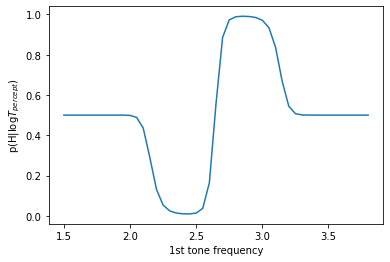

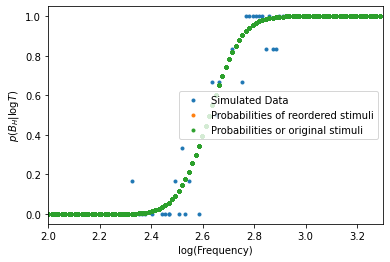

In [7]:
"""
One tone
Perceptual tones have a longer range than the experimental tones.
"""
trial_tones = np.copy(training_trials)

log_freq_percept = np.arange(np.log10(expt_tones[0])-0.5, np.log10(expt_tones[-1])+0.5, 0.05) 

prior_dist_mixed_high, prior_dist_mixed_low, posterior = \
posterior_array(log_freq_percept, n_tones=1, p_back=0.3, p_low=0.5, \
               log_prior_low=low_dist, log_prior_high=high_dist)
            
plt.plot(log_freq_percept,posterior)
plt.xlabel('1st tone frequency')
plt.ylabel('p(H|$\log T_{percept}$)')
plt.show()      
        
"""
Trying two routes - 1. what if we have both sensory noise in that the perceived tones are from a gaussian 
whose mean is the true tone and we have decision noise in that the at a particular perceived tone the observer 
chooses high with probability p(H|T). So a trial is basically defined as [trial_tone, perceived_tone and decision]
2. what if we only have sensory noise and the decision made is the best decision at a particular perceived tone. 

"""    
size = 6

all_trial_tones = np.empty((len(trial_tones)*size,1))
all_trial_behaviour = np.empty((len(trial_tones)*size,1))
prob_trial_behaviour = np.empty((len(trial_tones),1))
probability_high = np.zeros((len(trial_tones),1))

i_trial = 0
for i_stim in range(len(trial_tones)):
    i_trial += 1
    input_array = np.random.normal(loc=np.log10(trial_tones[i_stim]),scale=0.1,size=(size,1,n_tones)) \
    #pick tones from the gaussian with mean as log(true_tone) and sigma 0.1    
    for i_tperc in range(size):
        perc_tone_idxs = np.zeros((n_tones,1),dtype=int)
        for i in range(n_tones):
            perc_tone_idxs[i] = np.argmin(np.abs(log_freq_percept-input_array[i_tperc][0][i]))
            # find relevant adjacent freq percepts   
        posterior_perc_tone = posterior[perc_tone_idxs[0]]
        # trial_behaviour = (np.random.random_sample() < np.squeeze(posterior_perc_tone)).astype(int)
        # this encodes decision noise
        trial_behaviour = np.squeeze(posterior_perc_tone) > 0.5
        # this makes the same choice for one tone percept every time that tone is perceived   
        all_trial_behaviour[(i_trial-1)*size+i_tperc,:] = trial_behaviour
    all_trial_tones[(i_trial-1)*size:i_trial*size,:] = trial_tones[i_stim]    
    prob_trial_behaviour[i_stim] = np.mean(all_trial_behaviour[(i_trial-1)*size:i_trial*size])

    gaussian_prob_array = gaussian(log_freq_percept, mean = np.log10(trial_tones[i_stim]), sigma = 0.1)
    gaussian_prob_array /= np.sum(gaussian_prob_array)
    gaussian_prob_array = np.expand_dims(gaussian_prob_array, axis = 1)  
    probability_high[i_stim] = (np.transpose(posterior)>0.5)@gaussian_prob_array

probability_orig_high = np.zeros((len(orig_trial_tones),1))
    
for i_orig_stim in range(len(orig_trial_tones)):
    gaussian_prob_array = gaussian(log_freq_percept, mean = np.log10(orig_trial_tones[i_orig_stim]), sigma = 0.1)
    gaussian_prob_array /= np.sum(gaussian_prob_array)
    gaussian_prob_array = np.expand_dims(gaussian_prob_array, axis = 1)  
    probability_orig_high[i_orig_stim] = (np.transpose(posterior)>0.5)@gaussian_prob_array
    
fig = plt.figure()
ax = plt.axes()
ax.plot(np.log10(trial_tones),prob_trial_behaviour,'.')    
ax.plot(np.log10(trial_tones),probability_high,'.')
ax.plot(np.log10(orig_trial_tones),probability_orig_high,'.')
ax.legend(['Simulated Data','Probabilities of reordered stimuli','Probabilities or original stimuli'])
plt.xlim(np.log10(expt_tones[0]),np.log10(expt_tones[-1]))
plt.ylabel('$p(B_H|\log T)$')
plt.xlabel('log(Frequency)')

"""
Shuffling the tones and the behaviour to simluate an experiment
"""
s = np.arange(all_trial_tones.shape[0])
np.random.shuffle(s)
all_trial_tones = all_trial_tones[s]
all_trial_behaviour = all_trial_behaviour[s]

In [8]:
# define mle function
def MLE(params):
    log_prior_low_mean, log_prior_low_sigma, log_prior_high_mean, log_prior_high_sigma, p_back = \
    params[0], params[1], params[2], params[3], params[4] # inputs are guesses at our parameters
    
    prior_low = gaussian(x=log_freq_percept, mean=log_prior_low_mean, sigma=log_prior_low_sigma)
    prior_high = gaussian(x=log_freq_percept, mean=log_prior_high_mean, sigma=log_prior_high_sigma)
    prior_dist_mixed_high = p_back*(1/len(log_freq_percept)) + (1-p_back)*prior_high #mixture model
    prior_dist_mixed_high /= prior_dist_mixed_high.sum() #normalizing
    prior_dist_mixed_high = np.expand_dims(prior_dist_mixed_high, axis = 1)
    prior_dist_mixed_low = p_back*(1/len(log_freq_percept)) + (1-p_back)*prior_low #mixture model
    prior_dist_mixed_low /= prior_dist_mixed_low.sum() #normalizing
    prior_dist_mixed_low = np.expand_dims(prior_dist_mixed_low, axis = 1)

    if len(all_trial_tones[0]) == 3:
        prior_tones_low = np.expand_dims(prior_dist_mixed_low@np.transpose\
                                         (prior_dist_mixed_low),axis=2)@np.transpose(prior_dist_mixed_low) \
        #p(T1,T2..|L) 
        prior_tones_high = np.expand_dims(prior_dist_mixed_high@np.transpose\
                                          (prior_dist_mixed_high),axis=2)@np.transpose(prior_dist_mixed_high) \
        #p(T1,T2..|H) 
        
    elif len(all_trial_tones[0]) == 2:
        prior_tones_low = prior_dist_mixed_low@np.transpose(prior_dist_mixed_low)
        #p(T1,T2..|L) 
        prior_tones_high = prior_dist_mixed_high@np.transpose(prior_dist_mixed_high)
        #p(T1,T2..|H) 
        
    elif len(all_trial_tones[0]) == 1:
        prior_tones_low = prior_dist_mixed_low
        prior_tones_high = prior_dist_mixed_high
    
    p_low = 0.5 
    normalizer = (1-p_low)*prior_tones_high + p_low*prior_tones_low #p(H)*p(T1,T2..|H) + p(L)*p(T1,T2..|L)
    posterior = prior_tones_high*(1-p_low)/normalizer  
        
    neg_ll = 0; 
    probability_high = np.zeros((len(all_trial_tones),1))
    for i_etrial in range(len(all_trial_tones)):
        if len(all_trial_tones[i_etrial]) == 1:
            gaussian_prob_array = gaussian(log_freq_percept, \
                                           mean = np.log10(all_trial_tones[i_etrial][0]), sigma = 0.1)
            gaussian_prob_array /= np.sum(gaussian_prob_array)
            gaussian_prob_array = np.expand_dims(gaussian_prob_array, axis = 1)            
            probability_high0 = np.transpose(posterior>0.5)@gaussian_prob_array 
            probability_high[i_etrial] = np.transpose(posterior>0.5)@gaussian_prob_array \
            # np.transpose(behaviour0)@input_array        
            
        if all_trial_behaviour[i_etrial]:
            neg_ll += -np.log(probability_high0 + np.finfo(float).eps) # if high dist is chosen by observer
        else:
            neg_ll += -np.log(1 - probability_high0 + np.finfo(float).eps) # if low dist is chosen by observer
        if np.isnan(np.log(probability_high0 + 0.00001)) \
        or np.isinf(np.log(probability_high0 + 0.00001)) \
        or np.isnan(np.log(1 - probability_high0 + 0.00001)) \
        or np.isinf(np.log(1 - probability_high0 + 0.00001)):
            pdb.set_trace()        
    return(neg_ll)

In [9]:
guess_low_mean = np.arange(2,2.6,0.05); guess_low_sigma = np.arange(0.05,0.2,0.05)
guess_high_mean = np.arange(2.6,3.2,0.05); guess_high_sigma = np.arange(0.05,0.2,0.05)
guess_p_back = np.arange(0.05,1,0.05)
"""
Constraining guesses of means of low and high distributions based on observed behaviour in figure shown above. 
Currently estimating only means and p_back.
"""
neg_ll_array = np.zeros((len(guess_low_mean),len(guess_low_sigma),\
                         len(guess_high_mean),len(guess_high_sigma),len(guess_p_back)))
for lm in tqdm(range(len(guess_low_mean))):
    for ls in tqdm(range(len(guess_low_sigma)), leave=False, desc="Low sigma"):
        for hm in range(len(guess_high_mean)):
            for hs in range(len(guess_high_sigma)):
                for pb in range(len(guess_p_back)):
                    params = [guess_low_mean[lm], guess_low_sigma[ls], guess_high_mean[hm], \
                              guess_high_sigma[hs], guess_p_back[pb]]
                    # print(lm, hm, pb)
                    neg_ll_array[lm,ls,hm,hs,pb] = MLE(params)      

In [ ]:
# Means and p_back corresponding to the least negative log likelihood value
idxs = np.where(neg_ll_array == np.amin(neg_ll_array)) 
guess_low_mean[idxs[0]], guess_low_sigma[idxs[1]],  guess_high_mean[idxs[2]], \
guess_high_sigma[idxs[3]], guess_p_back[idxs[4]]

In [ ]:
neg_ll_array

In [ ]:
"""
Visualizing results from fitted parameters of one tone data
Perceptual tones have a longer range than the experimental tones.
"""

log_freq_percept = np.arange(np.log10(expt_tones[0])-0.5, np.log10(expt_tones[-1])+0.5, 0.05) 

prior_high_fit,prior_low_fit,posterior_fit = \
posterior_array(log_freq_percept, n_tones=1, p_back=guess_p_back[idxs[4]], p_low=0.5, \
                log_prior_low=[guess_low_mean[idxs[0]],guess_low_sigma[idxs[1]]],\
                log_prior_high=[guess_high_mean[idxs[2]],guess_high_sigma[idxs[3]]])

fig = plt.figure()
ax = plt.axes()
ax.plot(log_freq_percept,posterior)
ax.plot(log_freq_percept,posterior_fit)
ax.legend(['Original posterior','Fit posterior'])
plt.xlabel('1st tone frequency')
plt.ylabel('p(H|$\log T_{percept}$)')
plt.show()      
        
probability_high_fit = np.zeros((len(trial_tones),1))

i_trial = 0
for i_stim in range(len(trial_tones)):
    gaussian_prob_array = gaussian(log_freq_percept, mean = np.log10(trial_tones[i_stim]), sigma = 0.1)
    gaussian_prob_array /= np.sum(gaussian_prob_array)
    gaussian_prob_array = np.expand_dims(gaussian_prob_array, axis = 1)  
    probability_high_fit[i_stim] = np.transpose(posterior_fit)@gaussian_prob_array
    
fig = plt.figure()
ax = plt.axes()
ax.plot(np.log10(trial_tones),prob_trial_behaviour,'.') 
ax.plot(np.log10(trial_tones),probability_high,'.')
ax.plot(np.log10(trial_tones),probability_high_fit,'.')
ax.legend(['Simulated Data','Original probabilities','Fit probabilities'])
plt.xlim(np.log10(expt_tones[0]),np.log10(expt_tones[-1]))
plt.ylabel('$p(B_H|\log T)$')
plt.xlabel('log(Frequency)')
plt.savefig("with_decision_rule,multiplier={},n_tones={},n_trials={}".format(10,len(trial_tones),size))

"""
Shuffling the tones and the behaviour to simluate an experiment
"""
s = np.arange(all_trial_tones.shape[0])
np.random.shuffle(s)
all_trial_tones = all_trial_tones[s]
all_trial_behaviour = all_trial_behaviour[s]